# Loading Dataset

In [1]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
#logging.basicConfig(filename='output.log',level=logging.DEBUG)
#logging.basicConfig(filename='example.log', filemode='w', level=logging.DEBUG)

import numpy as np

from collections import defaultdict

def text2numpy(num, lines_list, dim, labels, l_dict=None, i_dict=None):

  
    
    X = np.zeros((num , dim))
    Y = np.zeros((num, labels))

    label_list = []

    for i,l in enumerate(lines_list[:num]):

        tokens=l.strip().split(",")
        values=tokens[1:]

        for d,v in enumerate(values):
            X[i,d] = float(v)
            
        if l_dict != None:
            Y[i, l_dict[tokens[0]]] = 1
        else:
            label_list.append(tokens[0])


    if l_dict == None:
        
        sorted_label_ind_list = [(x,i) for x,i in zip(sorted(list(set(label_list))),range(labels))]
        sorted_ind_label_list = [(i,x) for x,i in sorted_label_ind_list]

        l_dict = dict(sorted_label_ind_list)
        logging.debug("Label dict: {}".format(l_dict))
        
        i_dict = dict(sorted_ind_label_list)
        logging.debug("Index dict: {}".format(i_dict))

        for i in range(num_tr_examples):
            Y[i, l_dict[label_list[i]]] = 1

    
    
    return X,Y, l_dict, i_dict


f = open("DATASETS/letters/letter-recognition.data")

lines = f.readlines()

logging.debug("Input data sample: LABEL, V0, V1, ..., V15")
logging.debug("Input labels \in \{'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', \
       'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'}")

    

total_examples = len(lines)
logging.info("# Samples: {}".format(total_examples))

num_tr_examples = 16000
num_te_examples = total_examples - num_tr_examples
dim = 16
labels = 26

logging.info("# training samples: {}".format(num_tr_examples))
logging.info("# training samples: {}".format(num_te_examples))

X_tr, Y_tr, label_dict, ind_dict = text2numpy(num_tr_examples, lines, dim, labels)
X_te, Y_te, label_dict, ind_dict = text2numpy(num_te_examples, lines[num_tr_examples:],\
                                              dim, labels, label_dict, ind_dict)


logging.debug("Read examples: {}".format(X_tr[:10]))

for y in Y_tr[:10]:
    ind=np.argmax(y, axis=0)
    logging.debug("Read labels: {}".format(ind_dict[ind]))

for i in lines[:10]:
    logging.debug("Real instances: {}".format(i))

#Normalization -> From 0-15 to 0-1
X_tr = X_tr / 15.0
X_te = X_te / 15.0

logging.debug("Cheking things...{}".format(np.sum(Y_tr)))
logging.debug("Cheking things...{}".format(np.sum(Y_te)))

one_sample = X_tr[0,:].copy()
another_sample = X_tr[1,:].copy()

print((one_sample - another_sample))
print(np.sum(np.square(one_sample - another_sample)))

INFO:root:# Samples: 20000
INFO:root:# training samples: 16000
INFO:root:# training samples: 4000


[-0.2        -0.26666667  0.         -0.13333333 -0.06666667 -0.13333333
  0.53333333 -0.33333333  0.13333333 -0.46666667  0.46666667 -0.06666667
 -0.13333333  0.         -0.26666667 -0.13333333]
1.11111111111


# Preparing the model

In [2]:
#Condensed code based on the code from: https://jmetzen.github.io/2015-11-27/vae.html
%matplotlib inline

import numpy as np
import tensorflow as tf
import os

np.random.seed(0)
tf.set_random_seed(0)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def encoder(x, weights, biases):
    # Generate probabilistic encoder (recognition network), which
    # maps inputs onto a normal distribution in latent space.
    # The transformation is parametrized and can be learned.
    layer_1 = tf.nn.softplus(tf.add(tf.matmul(x, weights['h1']), biases['b1'])) 
    layer_2 = tf.nn.softplus(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])) 
    #Reparametrization trick
    z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']), biases['out_mean'])
    z_log_sigma_sq = tf.add(tf.matmul(layer_2, weights['out_log_sigma']), biases['out_log_sigma'])
    return (z_mean, z_log_sigma_sq)

def decoder(z, weights, biases):
    # Generate probabilistic decoder (decoder network), which
    # maps points in latent space onto a Bernoulli distribution in data space.
    # The transformation is parametrized and can be learned.
    layer_1 = tf.nn.softplus(tf.add(tf.matmul(z, weights['h1']), biases['b1'])) 
    layer_2 = tf.nn.softplus(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])) 
    #x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), biases['out_mean']))
    x_reconstr_mean = (tf.add(tf.matmul(layer_2, weights['out_mean']), biases['out_mean']))
    return x_reconstr_mean

def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)



# Instantiating the Model

In [3]:
X = X_tr
Y = Y_tr

logging.debug(np.mean(X,axis=0))
logging.debug(np.mean(X,axis=0).shape)

n_samples = X.shape[0]
x_dim = X.shape[1]
z_dim = 2

n_hidden_recog_1 = 128
n_hidden_recog_2 = 128

n_hidden_gener_1 = 128
n_hidden_gener_2 = 128

network_weights = dict()
network_weights['weights_recog'] = {
    'h1': tf.Variable(xavier_init(x_dim, n_hidden_recog_1)),
    'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
    'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, z_dim)),
    'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, z_dim))}
network_weights['biases_recog'] = {
    'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
    'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
    'out_mean': tf.Variable(tf.zeros([z_dim], dtype=tf.float32)),
    'out_log_sigma': tf.Variable(tf.zeros([z_dim], dtype=tf.float32))}

network_weights['weights_gener'] = {
    'h1': tf.Variable(xavier_init(z_dim, n_hidden_gener_1)),
    'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
    'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, x_dim)),
    'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, x_dim))}
network_weights['biases_gener'] = {
    'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
    'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
    'out_mean': tf.Variable(tf.zeros([x_dim], dtype=tf.float32)),
    'out_log_sigma': tf.Variable(tf.zeros([x_dim], dtype=tf.float32))}


#Original input
x_original = tf.placeholder(tf.float32, [None, x_dim])

#Encoding layer
z_mean, z_log_sigma_sq = encoder(x_original, network_weights["weights_recog"], network_weights["biases_recog"])

eps = tf.random_normal(shape=tf.shape(z_mean), mean=0.0, stddev=1.0, dtype=tf.float32)

#Sampling procedure
# z = mu + sigma*epsilon
z = tf.add(z_mean, tf.multiply(tf.sqrt(tf.exp(z_log_sigma_sq)), eps))

#Decoding layer
x_reconstructed = decoder(z, network_weights["weights_gener"], network_weights["biases_gener"])

#vector from outside to decode
z_input = tf.placeholder(tf.float32, shape=[None, z_dim])

#Decoding layer from outside's vector
x_reconstructed_sample = decoder(z_input, network_weights["weights_gener"], network_weights["biases_gener"])

#Reconstruction loss per sample (REVIEW)
per_sample_reconstructed_loss = tf.reduce_mean(tf.squared_difference(x_original, x_reconstructed), axis=1)

reconstructed_loss = tf.reduce_mean(per_sample_reconstructed_loss)

kl_divergence_vector = 1. + z_log_sigma_sq - tf.pow(z_mean, 2) - tf.exp(z_log_sigma_sq)

latent_loss = -.5 * tf.reduce_sum(kl_divergence_vector, reduction_indices=1)

cost = tf.reduce_mean(reconstructed_loss + latent_loss)

learning_rate=0.0001

optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)


# Training

In [4]:
MODELS_PATH = "models_vae/"

training_epochs = 1000
display_step = 100
batch_size = 100

init = tf.global_variables_initializer()

VAE_SAVER = tf.train.Saver()

if not os.path.exists(MODELS_PATH):
    os.makedirs(MODELS_PATH)
    
    
cost_list = []
cost_list_val = []

n_batches = n_samples // batch_size

X_val = X_te
Y_val = Y_te

n_samples_val = X_val.shape[0]

n_batches_val = n_samples_val // batch_size

logging.info("Total batches: {}".format(n_batches))

with tf.Session() as sess:
    
    sess.run(init)
    
    # Training cycle
    for epoch in range(training_epochs):
        
        avg_cost = 0.
        
        perm = np.random.permutation(X.shape[0])
        X = X[perm]
        Y = Y[perm]
        
        # Loop over all batches
        for batch_id in range(n_batches):
            batch_xs = X[batch_id * batch_size: (batch_id + 1) * batch_size]
    
            opt, curr_cost, per_sample_loss = sess.run((optimizer, reconstructed_loss,\
                                                        per_sample_reconstructed_loss), \
                                                       feed_dict={x_original: batch_xs})
            # Compute average loss
            avg_cost += curr_cost
            cost_list.append(curr_cost)
            
        # Display logs per epoch step
        if epoch % display_step == 0:
            
            logging.debug(per_sample_loss.shape)
            avg_cost_val = 0.
            
            for batch_id_val in range(n_batches_val):
                
                batch_xs_val = X_val[batch_id_val * batch_size: (batch_id_val + 1) * batch_size]

                curr_cost = sess.run((reconstructed_loss), feed_dict={x_original: batch_xs_val})
                # Compute average loss
                avg_cost_val += curr_cost
                cost_list_val.append(curr_cost)
            
            
            

            logging.info("Epoch: {:04d}, cost={:.9f}, cost (val) ={:.9f}".format(\
                epoch+1, avg_cost/n_batches, avg_cost_val/n_batches_val))            
    # Save model weights to disk
    save_path = VAE_SAVER.save(sess, MODELS_PATH + 'VANILLA_VAE.ckpt')
    print("Model saved in file: {}".format(save_path))

INFO:root:Total batches: 160
INFO:root:Epoch: 0001, cost=1.509039852, cost (val) =1.111534789
INFO:root:Epoch: 0101, cost=0.027531200, cost (val) =0.027183037
INFO:root:Epoch: 0201, cost=0.026605075, cost (val) =0.026527134
INFO:root:Epoch: 0301, cost=0.025982892, cost (val) =0.025787230
INFO:root:Epoch: 0401, cost=0.025507674, cost (val) =0.025345980
INFO:root:Epoch: 0501, cost=0.025174620, cost (val) =0.024933046
INFO:root:Epoch: 0601, cost=0.024878160, cost (val) =0.024727884
INFO:root:Epoch: 0701, cost=0.024691722, cost (val) =0.024437771
INFO:root:Epoch: 0801, cost=0.024506832, cost (val) =0.024311324
INFO:root:Epoch: 0901, cost=0.024352633, cost (val) =0.024179294


Model saved in file: models_vae/VANILLA_VAE.ckpt


# Projection

Total batches: 160
Model restored in file: models_vae/VANILLA_VAE.ckpt


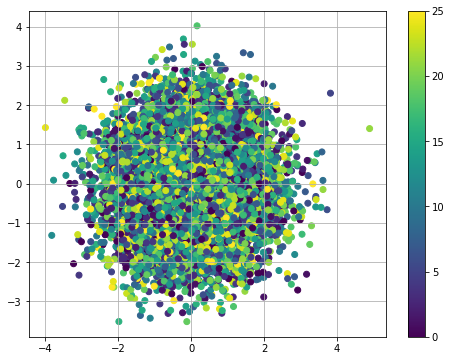

In [5]:
n_samples = X.shape[0]

batch_size = 100

n_batches = n_samples // batch_size

Z_gen = np.zeros((n_samples, z_dim))

print("Total batches: {}".format(n_batches))

with tf.Session() as sess:
    
    sess.run(init)
    
    VAE_SAVER.restore(sess, save_path)
    print("Model restored in file: {}".format(save_path))
    
    # Loop over all batches
    for batch_id in range(n_batches):

        batch_xs = X[batch_id * batch_size: (batch_id + 1) * batch_size]

        batch_gen = sess.run(( z), feed_dict={x_original: batch_xs})

        Z_gen[batch_id * batch_size: (batch_id + 1) * batch_size] = batch_gen.copy()


        
np.save('DATASETS/letters_Z_X_training.npy', Z_gen)
np.save('DATASETS/letters_Z_Y_training.npy', Y)

plt.figure(figsize=(8, 6)) 
plt.scatter(Z_gen[:, 0], Z_gen[:, 1], c=np.argmax(Y, 1))
plt.colorbar()
plt.grid()

# PCA comparison 

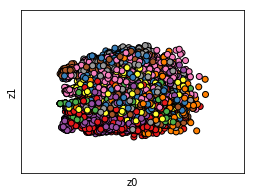

INFO:root:Considering label=0 (letter=A) and label=1(letter=B)


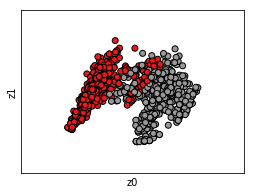

In [40]:
%matplotlib inline
# Code source: GaÃ«l Varoquaux
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

np.random.seed(0)

X = X_tr
y = np.argmax(Y_tr, axis=1)

fig = plt.figure(1, figsize=(4, 3))
plt.clf()
pca = PCA(n_components=2)
pca.fit(X)
Z = pca.transform(X)

x_min, x_max = Z[:, 0].min() - .5, Z[:, 0].max() + .5
y_min, y_max = Z[:, 1].min() - .5, Z[:, 1].max() + .5

# Plot the training points
plt.scatter(Z[:, 0], Z[:, 1], c=y, cmap=plt.cm.Set1, edgecolor='k')
plt.xlabel('z0')
plt.ylabel('z1')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

plt.show()

label1 = 0
label2 = 1
#Fewer labels...
indices = np.where((y == 0) | (y == 25))

logging.info("Considering label={} (letter={}) and label={}(letter={})".format(label1,\
                                                                               ind_dict[label1],\
                                                                               label2,\
                                                                               ind_dict[label2]))

X = X_tr[indices]
y = y[indices]

fig = plt.figure(1, figsize=(4, 3))
plt.clf()
pca = PCA(n_components=2)
pca.fit(X)
Z = pca.transform(X)

x_min, x_max = Z[:, 0].min() - .5, Z[:, 0].max() + .5
y_min, y_max = Z[:, 1].min() - .5, Z[:, 1].max() + .5

# Plot the training points
plt.scatter(Z[:, 0], Z[:, 1], c=y, cmap=plt.cm.Set1, edgecolor='k')
plt.xlabel('z0')
plt.ylabel('z1')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

plt.show()




